In [1]:
import sys
import os

import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import datetime as dt
from scipy import stats
from pathlib import Path

from datetime import timedelta
from collections import defaultdict

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
dir_base = Path(paths.dir_main)

dir_out_figures = dir_base / "outputs"

fn_avhrr = dir_base / "avhrr_hotspots_masked.csv"
fn_modis_aqua_am = dir_base / "aux_data/modis/MODIS_aqua_hotspots_masked_am.csv.gz"

load and unify

In [14]:
avhrr = pd.read_csv(str(fn_avhrr))
avhrr = avhrr[['lat','lon180','lon360','dt_utc','dt_lst','month','year','doy','gfed','gfed_name']]
avhrr['datetime'] = pd.to_datetime(avhrr['dt_lst'])
avhrr['dt_utc'] = pd.to_datetime(avhrr['dt_utc'])
avhrr = avhrr.rename(columns={'lat': 'latitude'})
avhrr = avhrr.rename(columns={'lon180': 'longitude'})
# remove years before 2003 (no good MODIS data)
avhrr = avhrr.loc[avhrr.year > 2002,:]

modis = pd.read_csv(str(fn_modis_aqua_am))
modis['datetime'] = pd.to_datetime(modis['dt_lst'])
modis['dt_utc'] = pd.to_datetime(modis['dt_utc'])
modis = modis.rename(columns={'lat': 'latitude'})
modis = modis.rename(columns={'lon180': 'longitude'})

In [15]:
np.unique(avhrr.year)

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016], dtype=int64)

In [25]:
#print(avhrr.head())
#print(modis.head())

    latitude  longitude      lon360                        dt_utc                      dt_lst  month  year  doy  gfed gfed_name                   datetime
0 -54.635223 -67.265503  292.734497 2001-12-23 05:04:06.155548096  2001-12-23 00:36:24.786590     12  2001  357     5      SHSA 2001-12-23 00:36:24.786590
1 -54.620804 -67.312286  292.687714 2008-12-09 05:25:04.692649839  2008-12-09 01:03:28.218514     12  2008  344     5      SHSA 2008-12-09 01:03:28.218514
2 -54.559692 -67.150970  292.849030 2011-10-24 05:30:17.506027220  2011-10-24 01:17:32.783680     10  2011  297     5      SHSA 2011-10-24 01:17:32.783680
3 -54.115570 -70.304169  289.695831 1990-02-24 05:24:31.174049376  1990-02-24 00:29:37.475247      2  1990   55     5      SHSA 1990-02-24 00:29:37.475247
4 -53.381866 -72.748322  287.251678 1996-01-22 06:00:23.641204834  1996-01-22 00:58:35.424258      1  1996   22     5      SHSA 1996-01-22 00:58:35.424258
   latitude  longitude   lon360              dt_utc                   

### process

params

In [5]:
GRID_SIZE = 1.0  # spatial grid size in degrees
TEMPORAL_TOLERANCE = timedelta(hours=12)  # ±12h temporal window

helper funcs

In [16]:
def assign_grid_cells(df, lat_col='latitude', lon_col='longitude'):
    df = df.copy()
    df['lat_bin'] = (np.floor(df[lat_col] / GRID_SIZE) * GRID_SIZE).astype(float)
    df['lon_bin'] = (np.floor(df[lon_col] / GRID_SIZE) * GRID_SIZE).astype(float)
    return df


def match_detections(modis_df, avhrr_df):
    """
    Compare MODIS (truth) and AVHRR detections.
    A true positive (TP) occurs when any AVHRR detection exists in the same grid cell
    within the ±12 hour temporal tolerance of a MODIS detection.
    
    False negatives (FN) are MODIS detections with no AVHRR within tolerance.
    False positives (FP) are AVHRR detections with no MODIS within tolerance.
    """
    # Organize AVHRR detections by spatial grid cell
    avhrr_lookup = defaultdict(list)
    for idx, row in avhrr_df.iterrows():
        key = (row['lat_bin'], row['lon_bin'])
        avhrr_lookup[key].append((idx, row))

    matched_avhrr_idx = set()
    matched_modis = set()
    fn_set = set()

    for midx, modis_row in modis_df.iterrows():
        key = (modis_row['lat_bin'], modis_row['lon_bin'])
        candidates = avhrr_lookup.get(key, [])

        matched = False
        for cand_idx, cand in candidates:
            if abs(modis_row['datetime'] - cand['datetime']) <= TEMPORAL_TOLERANCE:
                matched = True
                matched_modis.add(midx)
                matched_avhrr_idx.add(cand_idx)
        if not matched:
            fn_set.add(midx)

    # Check AVHRR for unmatched detections
    fp_set = set()
    for idx, row in avhrr_df.iterrows():
        if idx not in matched_avhrr_idx:
            key = (row['lat_bin'], row['lon_bin'])
            # Only mark as FP if no MODIS is within tolerance
            modis_candidates = modis_df[(modis_df['lat_bin'] == key[0]) &
                                        (modis_df['lon_bin'] == key[1])]
            if all(abs(row['datetime'] - m['datetime']) > TEMPORAL_TOLERANCE for _, m in modis_candidates.iterrows()):
                fp_set.add(idx)

    TP = len(matched_modis)
    FN = len(fn_set)
    FP = len(fp_set)

    return TP, FN, FP

def match_detections_vectorized(modis_df, avhrr_df):
    """
    Vectorized comparison between MODIS (truth) and AVHRR detections.
    A true positive (TP) occurs when any AVHRR detection exists in the same grid cell
    within the ±12 hour temporal tolerance of a MODIS detection.
    False negatives (FN) are MODIS detections with no AVHRR within tolerance.
    False positives (FP) are AVHRR detections with no MODIS within tolerance.
    """
    modis_df = modis_df.reset_index(drop=True).copy()
    avhrr_df = avhrr_df.reset_index(drop=True).copy()
    modis_df['index_modis'] = modis_df.index
    avhrr_df['index_avhrr'] = avhrr_df.index
    
    
    merged = pd.merge(modis_df, avhrr_df, on=['lat_bin', 'lon_bin'], suffixes=('_modis', '_avhrr'))
    merged['time_diff'] = abs(merged['datetime_modis'] - merged['datetime_avhrr'])
    
    
    matched = merged[merged['time_diff'] <= TEMPORAL_TOLERANCE]
    
    
    matched_modis_idx = set(matched['index_modis'])
    matched_avhrr_idx = set(matched['index_avhrr'])
    
    
    TP = len(matched_modis_idx)
    FN = len(modis_df) - TP
    FP = len(avhrr_df) - len(matched_avhrr_idx)
    
    
    return TP, FN, FP

def compute_metrics(TP, FN, FP):
    omission_rate = FN / (TP + FN) if (TP + FN) > 0 else np.nan
    commission_rate = FP / (TP + FP) if (TP + FP) > 0 else np.nan
    return omission_rate, commission_rate


# def assign_region(df, region_mask, lat_bins, lon_bins):
#     df = df.copy()
#     region_ids = []
#     for lat, lon in zip(df['latitude'], df['longitude']):
#         lat_idx = np.digitize(lat, lat_bins) - 1
#         lon_idx = np.digitize(lon, lon_bins) - 1
#         if 0 <= lat_idx < region_mask.shape[0] and 0 <= lon_idx < region_mask.shape[1]:
#             region_ids.append(region_mask[lat_idx, lon_idx])
#         else:
#             region_ids.append(-1)
#     df['region_id'] = region_ids
#     return df



main function

In [7]:
def run_analysis(modis_df, avhrr_df, region_mask=None):
    # Ensure datetime
    modis_df['datetime'] = pd.to_datetime(modis_df['datetime'])
    avhrr_df['datetime'] = pd.to_datetime(avhrr_df['datetime'])

    # Assign grid cells
    modis_df = assign_grid_cells(modis_df)
    avhrr_df = assign_grid_cells(avhrr_df)

    # Add year for grouping
    modis_df['year'] = modis_df['datetime'].dt.year
    avhrr_df['year'] = avhrr_df['datetime'].dt.year

    results = []

    if region_mask is not None:
        # Define grid for region assignment
        lat_bins = np.arange(-90, 90 + GRID_SIZE, GRID_SIZE)
        lon_bins = np.arange(-180, 180 + GRID_SIZE, GRID_SIZE)

        modis_df = assign_region(modis_df, region_mask, lat_bins, lon_bins)
        avhrr_df = assign_region(avhrr_df, region_mask, lat_bins, lon_bins)

        region_ids = sorted(set(modis_df['region_id']) & set(avhrr_df['region_id']))

        for region in region_ids:
            modis_r = modis_df[modis_df['region_id'] == region]
            avhrr_r = avhrr_df[avhrr_df['region_id'] == region]

            # All years
            TP, FN, FP = match_detections(modis_r, avhrr_r)
            omission, commission = compute_metrics(TP, FN, FP)
            results.append({'region': region, 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
                            'omission_rate': omission, 'commission_rate': commission})

            # Per year
            years = sorted(set(modis_r['year']) | set(avhrr_r['year']))
            for year in years:
                modis_y = modis_r[modis_r['year'] == year]
                avhrr_y = avhrr_r[avhrr_r['year'] == year]
                TP, FN, FP = match_detections(modis_y, avhrr_y)
                omission, commission = compute_metrics(TP, FN, FP)
                results.append({'region': region, 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                                'omission_rate': omission, 'commission_rate': commission})

    else:
        # ---- Overall (multi-year) analysis ----
        print(f'doing multi-year analysis')
        TP, FN, FP = match_detections(modis_df, avhrr_df)
        omission, commission = compute_metrics(TP, FN, FP)
        results.append({'region': 'Global', 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
                        'omission_rate': omission, 'commission_rate': commission})

        # ---- Per-year analysis ----
        years = sorted(set(modis_df['year']) | set(avhrr_df['year']))
        if len(years) > 1:
            for year in years:
                print(f'doing year {year}')
                modis_y = modis_df[modis_df['year'] == year]
                avhrr_y = avhrr_df[avhrr_df['year'] == year]
    
                TP, FN, FP = match_detections(modis_y, avhrr_y)
                omission, commission = compute_metrics(TP, FN, FP)
                results.append({'region': 'Global', 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                                'omission_rate': omission, 'commission_rate': commission})

    return pd.DataFrame(results)

In [31]:
# result_df = run_analysis(modis_df=modis.loc[modis.year == 2016,:].copy(), 
#                          avhrr_df=avhrr.loc[avhrr.year == 2016,:].copy(), 
#                          region_mask=None)
# print(result_df)

doing multi-year analysis
   region year     TP     FN    FP  omission_rate  commission_rate
0  Global  All  24444  81482  9676       0.769235         0.283587


a ~0.77 omission rate is actually in line with expectations; due to the GAC resampling scheme, you only end up with information from 4 of every 15 LAC pixels (which are 1km, comparable to MODIS). so all else being equal, AVHRR should at best detect 4/15ths as much fire as modis (4/15 = 0.27, 1-0.27 = 0.73)

The detection rate should in fact be even lower, because the 4 LAC pixels are averaged to get 1 GAC pixel, which will further supress detection - easily explaining omission rate of 0.77.

More problematic is a comission rate of 0.28..

In [34]:
#4/15

0.26666666666666666

This version allows you to run regional and global, and has substantial speed improvements by using a pandas based vectorized matching process, rather than loop iteration.

In [25]:
def run_analysis(modis_df, avhrr_df, calc_overall_error=False, regional=False):
    """
    Run omission/commission analysis.
    If regional=True, break down results by 'gfed' regions.
    Always outputs global results overall and by year.
    """
    results = []
    
    # Ensure datetime format
    modis_df['datetime'] = pd.to_datetime(modis_df['datetime'])
    avhrr_df['datetime'] = pd.to_datetime(avhrr_df['datetime'])

    # Assign grid cells
    modis_df = assign_grid_cells(modis_df)
    avhrr_df = assign_grid_cells(avhrr_df)

    # Add year
    modis_df['year'] = modis_df['datetime'].dt.year
    avhrr_df['year'] = avhrr_df['datetime'].dt.year

    # ---- Global analysis ----
    if calc_overall_error:
        print(f'doing global - all years. Note: This will be slow; the vectorized solution causes out of memory errors so this is run iteratively.')
        TP, FN, FP = match_detections(modis_df, avhrr_df)
        #TP, FN, FP = match_detections_vectorized(modis_df, avhrr_df) <-- causes memory errors!
        omission, commission = compute_metrics(TP, FN, FP)
        results.append({'region': 'Global', 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
                        'omission_rate': omission, 'commission_rate': commission})
    else:
        print(f'skipping global - all years.')
    
    years = sorted(set(modis_df['year']).intersection(set(avhrr_df['year'])))
    print(f'\nIndividual years to run: {years}\n')
    
    for year in years:
        print(f'doing global - year {year}')
        modis_y = modis_df[modis_df['year'] == year]
        avhrr_y = avhrr_df[avhrr_df['year'] == year]
        #TP, FN, FP = match_detections(modis_y, avhrr_y)
        TP, FN, FP = match_detections_vectorized(modis_y, avhrr_y)
        omission, commission = compute_metrics(TP, FN, FP)
        results.append({'region': 'Global', 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                        'omission_rate': omission, 'commission_rate': commission})

    # ---- Regional analysis ----
    if regional:
        regions = sorted(set(modis_df['gfed']).intersection(set(avhrr_df['gfed'])))
        print(f'\nRunning regional. \nIndividual regions to run: {regions}\n')
        for region in regions:
            print(f'doing regional - all years. Region: {region}')
            modis_r = modis_df[modis_df['gfed'] == region]
            avhrr_r = avhrr_df[avhrr_df['gfed'] == region]
            #TP, FN, FP = match_detections(modis_r, avhrr_r)
            #TP, FN, FP = match_detections_vectorized(modis_r, avhrr_r)
            #omission, commission = compute_metrics(TP, FN, FP)
            gfed_name = modis_r['gfed_name'].iloc[0] if not modis_r.empty else avhrr_r['gfed_name'].iloc[0]
            #results.append({'region': gfed_name, 'year': 'All', 'TP': TP, 'FN': FN, 'FP': FP,
            #                'omission_rate': omission, 'commission_rate': commission})
            
            for year in sorted(set(modis_r['year']).intersection(set(avhrr_r['year']))):
                print(f'doing region {region} - year {year}')
                modis_y = modis_r[modis_r['year'] == year]
                avhrr_y = avhrr_r[avhrr_r['year'] == year]
                #TP, FN, FP = match_detections(modis_y, avhrr_y)
                TP, FN, FP = match_detections_vectorized(modis_y, avhrr_y)
                omission, commission = compute_metrics(TP, FN, FP)
                results.append({'region': gfed_name, 'year': year, 'TP': TP, 'FN': FN, 'FP': FP,
                                'omission_rate': omission, 'commission_rate': commission})

    return pd.DataFrame(results)

In [10]:
result_df = run_analysis(modis_df=modis.loc[modis.year < 2004,:].copy(), 
                         avhrr_df=avhrr.loc[avhrr.year < 2004,:].copy(), 
                         regional=False)
print(result_df)

doing global - all years
Individual years to run: [2003]
doing global - year 2003
   region  year     TP     FN      FP  omission_rate  commission_rate
0  Global   All  36391  99845  275560       0.732883         0.883344
1  Global  2003  36391  99845   14161       0.732883         0.280127


In [26]:
result_df = run_analysis(modis_df=modis.loc[:].copy(), 
                         avhrr_df=avhrr.loc[:].copy(), 
                         calc_overall_error=False,
                         regional=True)
print(result_df)
result_df.to_csv(dir_out_figures / 'error_analysis_1deg_12h.csv', index=False)

skipping global - all years.

Individual years to run: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

doing global - year 2003
doing global - year 2004
doing global - year 2005
doing global - year 2006
doing global - year 2007
doing global - year 2008
doing global - year 2009
doing global - year 2010
doing global - year 2011
doing global - year 2012
doing global - year 2013
doing global - year 2014
doing global - year 2015
doing global - year 2016

Running regional. 
Individual regions to run: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

doing regional - all years. Region: 0
doing region 0 - year 2003
doing region 0 - year 2004
doing region 0 - year 2005
doing region 0 - year 2006
doing region 0 - year 2007
doing region 0 - year 2008
doing region 0 - year 2009
doing region 0 - year 2010
doing region 0 - year 2011
doing region 0 - year 2012
doing region 0 - year 2013
doing region 0 - year 2014
doing region 0 - year 2015
doing region 0 - year

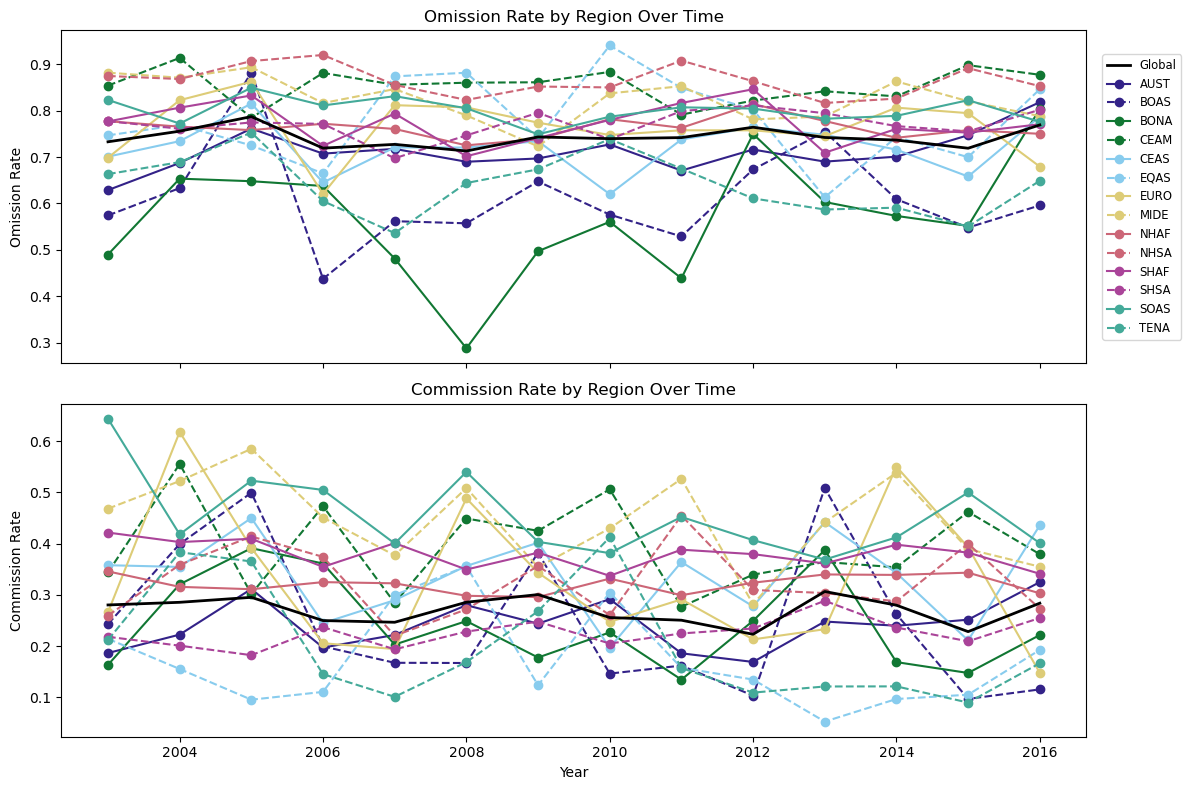

In [39]:
import itertools

# Use Paul Tol's colorblind-friendly palette (7 colors)
# Source: https://personal.sron.nl/~pault/
colorblind_colors = [
    '#332288',  # dark blue
    '#117733',  # green
    '#88CCEE',  # cyan
    '#DDCC77',  # sand
    '#CC6677',  # red
    '#AA4499',  # purple
    '#44AA99'   # teal
]

# Split global and regional data
global_df = result_df[result_df['region'] == 'Global'].copy()
regional_df = result_df[result_df['region'] != 'Global'].copy()
regional_df = regional_df[regional_df['region'] != 'Mask'].copy()

# Filter out the 'All' year row and ensure year is numeric
global_df = global_df[global_df['year'] != 'All']
regional_df = regional_df[regional_df['year'] != 'All']

global_df['year'] = pd.to_numeric(global_df['year'])
regional_df['year'] = pd.to_numeric(regional_df['year'])

regions = sorted(regional_df['region'].unique())

# Define 7 colors and 2 line styles → 14 unique combinations
#colors = plt.get_cmap('tab10').colors[:7]  # pick first 7 tab10 colors
line_styles = ['-', '--']
style_combinations = list(itertools.product(colorblind_colors, line_styles))

# Create mapping of region to (color, linestyle)
region_styles = {region: style_combinations[i] for i, region in enumerate(regions)}

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# === Omission rate ===
# Global line
ax1.plot(global_df['year'], global_df['omission_rate'], 
         color='black', linestyle='-', linewidth=2, label='Global',zorder=100)

# Regional lines
for region in regions:
    subset = regional_df[regional_df['region'] == region]
    color, style = region_styles[region]
    ax1.plot(subset['year'], subset['omission_rate'], 
             label=region, color=color, linestyle=style, marker='o')

ax1.set_ylabel('Omission Rate')
ax1.set_title('Omission Rate by Region Over Time')
ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize='small')

# === Commission rate ===
# Global line
ax2.plot(global_df['year'], global_df['commission_rate'], 
         color='black', linestyle='-', linewidth=2, label='Global',zorder=100)

# Regional lines
for region in regions:
    subset = regional_df[regional_df['region'] == region]
    color, style = region_styles[region]
    ax2.plot(subset['year'], subset['commission_rate'], 
             label=region, color=color, linestyle=style, marker='o')

ax2.set_xlabel('Year')
ax2.set_ylabel('Commission Rate')
ax2.set_title('Commission Rate by Region Over Time')

plt.tight_layout()
plt.show()

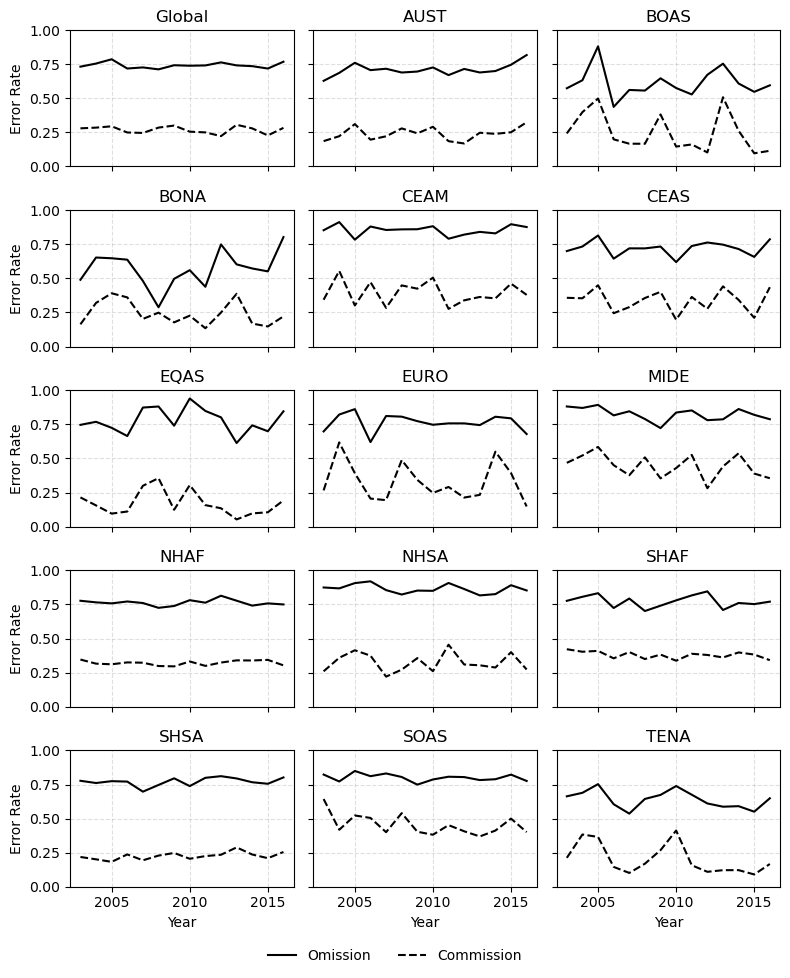

In [53]:
result_df = result_df[result_df['region'] != 'Mask'].copy()
result_df = result_df[result_df['year'] != 'All'].copy()
result_df['year'] = pd.to_numeric(result_df['year'])

all_regions = sorted(result_df['region'].unique(), key=lambda x: (x != 'Global', x))
n_panels = len(all_regions)

ncols = 3
nrows = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, region in enumerate(all_regions):
    ax = axes[i]
    region_data = result_df[result_df['region'] == region].sort_values(by='year')

    ax.plot(region_data['year'], region_data['omission_rate'],
            color='black', linestyle='-', label='Omission')
    ax.plot(region_data['year'], region_data['commission_rate'],
            color='black', linestyle='--', label='Commission')

    ax.set_title(region)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.4)

    if i % ncols == 0:
        ax.set_ylabel('Error Rate')
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel('Year')

# Hide unused axes
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

# Shared legend below the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

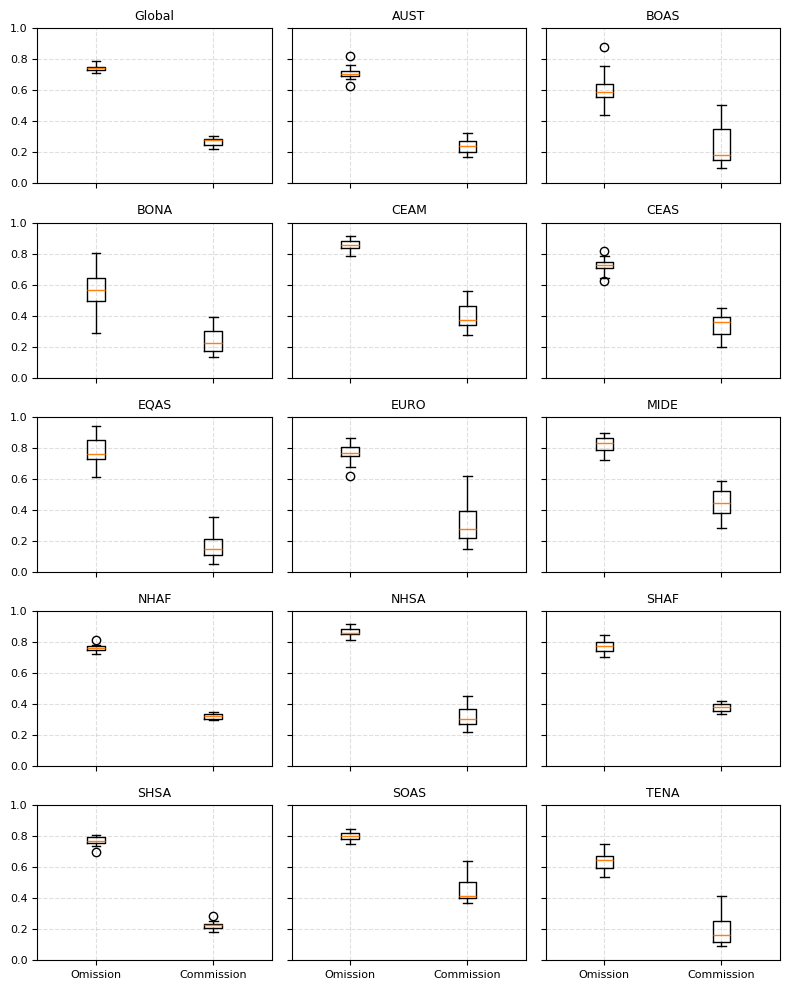

In [57]:
# Filter and prepare data
result_df = result_df[result_df['region'] != 'Mask'].copy()
result_df = result_df[result_df['year'] != 'All'].copy()
result_df['year'] = pd.to_numeric(result_df['year'])

# Sort regions, ensuring 'Global' is first
all_regions = sorted(result_df['region'].unique(), key=lambda x: (x != 'Global', x))
n_panels = len(all_regions)

# Layout settings
ncols = 3
nrows = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, region in enumerate(all_regions):
    ax = axes[i]
    data = result_df[result_df['region'] == region]
    
    omission_data = data['omission_rate'].dropna()
    commission_data = data['commission_rate'].dropna()
    
    ax.boxplot([omission_data, commission_data], positions=[1, 2])
    
    ax.set_title(region, fontsize=9)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Omission', 'Commission'], fontsize=8)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='y', labelsize=8)
   
    ax.grid(True, linestyle='--', alpha=0.4)
    
# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### testing to make sure the matching code works

In [63]:
asub = avhrr.loc[(avhrr.year == 2016) & (avhrr.doy == 222), :].copy()
msub = modis.loc[(modis.year == 2016) & (modis.doy == 222), :].copy()

(367, 13)